Now we are analysing the dynamics of price changes over time to infer relationships and understand underlying patterns.

Time Series Decomposition: We took the price of a single product ("Heinz Tomato Ketchup Bottle" at Tesco) and broke it down. We separated the price movement into its core components to understand how it behaves.

Cross-Correlation: We took the price series from two different stores (Sainsbury's and Tesco) and statistically measured if one store's price changes consistently happen before the other's. This helps us infer competitive dynamics like price leadership.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import process, fuzz
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_processing import normalise_product_name

In [16]:
sns.set_theme(style="whitegrid")
PROCESSED_DATA_PATH = "C:/Project/UK store analysis/data/02_processed/canonical_products_e5.parquet"
df_canonical = pd.read_parquet(PROCESSED_DATA_PATH)

print("Canonical product data loaded successfully.")

Canonical product data loaded successfully.


In [17]:
df_canonical.sample(10)

,supermarket,prices,prices_unit,unit,names,date,category,own_brand,normalized_name,canonical_name
7088944,Sains,1.00,2.50,kg,Napolina Peeled Plum Tomatoes 400g,2024-01-17,food_cupboard,False,napolina peeled plum tomatoes,napolina peeled plum tomatoes
9213867,Tesco,2.89,0.13,unit,Fred & Flo Ultra Dry Size 7 Nappies 22Pack,2024-01-22,baby_products,True,fred flo ultra dry size 7 nappies,fred flo ultra dry size 7 nappies
4527313,Morrisons,13.00,3.94,l,Birra Moretti Lager Beer Cans,2024-01-19,drinks,False,birra moretti lager beer cans,birra moretti lager beer cans
8389306,Tesco,3.00,20.00,kg,JoJo Maman Bebe BATH FIZZER COLLECTION 3x50g,2024-02-28,health_products,False,jojo maman bebe bath fizzer collection 3x50g,jojo maman bebe bath fizzer collection 3x50g
8679681,Tesco,9.00,4.50,kg,Scrumbles Chicken Dry Dog Food 2Kg,2024-02-16,pets,False,scrumbles chicken dry dog food,scrumbles chicken dry dog food
2789641,ASDA,0.90,6.00,kg,ASDA 12 Lemon Jaffa Cakes,2024-01-14,food_cupboard,True,12 lemon jaffa cakes,12 lemon jaffa cakes
4428619,Morrisons,1.50,1.50,unit,Morrisons Market St Living Coriander,2024-01-25,fresh_food,True,market st living coriander,market st living coriander
7183157,Sains,1.00,6.00,kg,McVitie's Digestives Creams Vanilla Biscuits 168g,2024-01-13,food_cupboard,False,mcvities digestives creams vanilla biscuits,mcvities digestives creams chocolate biscuits
1810952,ASDA,4.00,4.00,unit,Megamonster by David Walliams,2024-02-22,home,False,megamonster by david walliams,megamonster by david walliams
5708432,Sains,2.20,48.90,kg,Misfits Plant Powered Choc Protein Bar Chocola...,2024-03-07,health_products,False,misfits plant powered choc protein bar chocola...,misfits plant powered choc protein bar chocola...


# Time Series Decomposition

Supermarkets: ['Sains', 'Tesco']


C:\Users\bharg\AppData\Local\Temp\ipykernel_66188\1300995201.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_pivot[supermarket_name] = ts_pivot[supermarket_name].fillna(method='ffill')


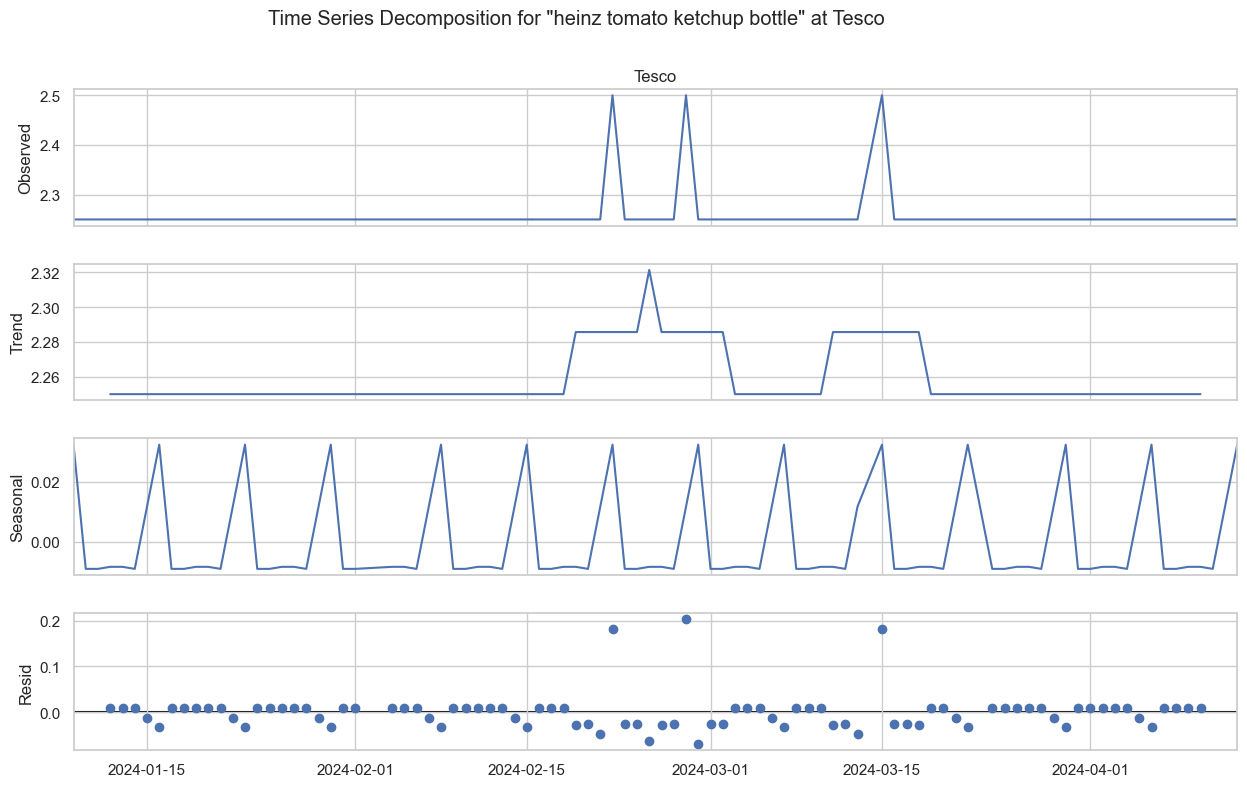

In [24]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Convert date to datetime
df_canonical['date'] = pd.to_datetime(df_canonical['date'])

# Filter for the product and sort by date
product_name = 'heinz tomato ketchup bottle'
ts_data = df_canonical[df_canonical['canonical_name'] == product_name].sort_values('date')

# Pivot with aggregation to handle duplicates
ts_pivot = ts_data.pivot_table(
    index='date',
    columns='supermarket',
    values='prices',
    aggfunc='mean'
)

# Check available supermarkets
print("Supermarkets:", ts_pivot.columns.tolist())

# Pick a supermarket (make sure it exists)
supermarket_name = 'Tesco'
if supermarket_name not in ts_pivot.columns:
    raise ValueError(f'Supermarket "{supermarket_name}" not found in data.')

# Forward fill missing values and drop remaining NaNs
ts_pivot[supermarket_name] = ts_pivot[supermarket_name].fillna(method='ffill')
ts_pivot = ts_pivot.dropna(subset=[supermarket_name])

# Check length
if len(ts_pivot[supermarket_name]) < 14:
    raise ValueError("Not enough data points for seasonal decomposition.")

# Decompose
decomposition = seasonal_decompose(ts_pivot[supermarket_name], model='additive', period=7)

# Plot
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle(f'Time Series Decomposition for "{product_name}" at {supermarket_name}', y=1.02)

# Set the y-label for the first subplot (Observed)
fig.axes[0].set_ylabel('Observed')

plt.show()

* Top Panel: Observed
    * What it shows: This is the actual, raw price of the ketchup bottle at Tesco each day.
    * Interpretation: The price is mostly stable at around £2.25. However, we see three distinct, short-lived price spikes to £2.50. These are likely promotional periods ending or temporary price increases. After each spike, the price quickly returns to its base level.

* Second Panel: Trend
    * What it shows: This is the underlying long-term direction of the price, with short-term fluctuations and seasonality smoothed out. The statsmodels library calculates this using a moving average.
    * Interpretation: The trend shows a slight, stepwise increase over the period. It starts around £2.25, moves up to ~£2.29, dips, and then settles back around £2.28. This tells us that, ignoring the promotional noise, the base price of ketchup has crept up slightly over these three months. This could be due to inflation or a subtle strategic price increase.

* Third Panel: Seasonal
    * What it shows: This is the repeating, periodic pattern in the data. Since we set period=7, it's showing the average price fluctuation for each day of the week.
    * Interpretation: We see a clear, repeating "sawtooth" pattern every 7 days. This indicates a strong weekly seasonality. Some days of the week, the price is consistently slightly higher or lower than the trend. This could be Tesco's system for rolling out weekly offers. For example, the price might dip every Wednesday when new promotions start.

* Bottom Panel: Resid (Residuals)
    * What it shows: This is what's left over after subtracting the Trend and the Seasonal components from the Observed price. It represents the random, unpredictable noise or one-off events.
    * Interpretation: Most of the residuals are clustered around zero, which is good—it means our model has explained the trend and seasonality well. However, there are a few significant spikes (e.g., around late February). These are anomalies. They could be data errors, or more likely, very short-term events (like a one-day "flash sale" or its end) that don't fit the regular weekly pattern.


# Cross Correlation Analysis

Available supermarkets in ts_pivot: ['Sains', 'Tesco']


C:\Users\bharg\AppData\Local\Temp\ipykernel_66188\2500243764.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_pivot[supermarket1] = ts_pivot[supermarket1].fillna(method='ffill')
C:\Users\bharg\AppData\Local\Temp\ipykernel_66188\2500243764.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_pivot[supermarket2] = ts_pivot[supermarket2].fillna(method='ffill')


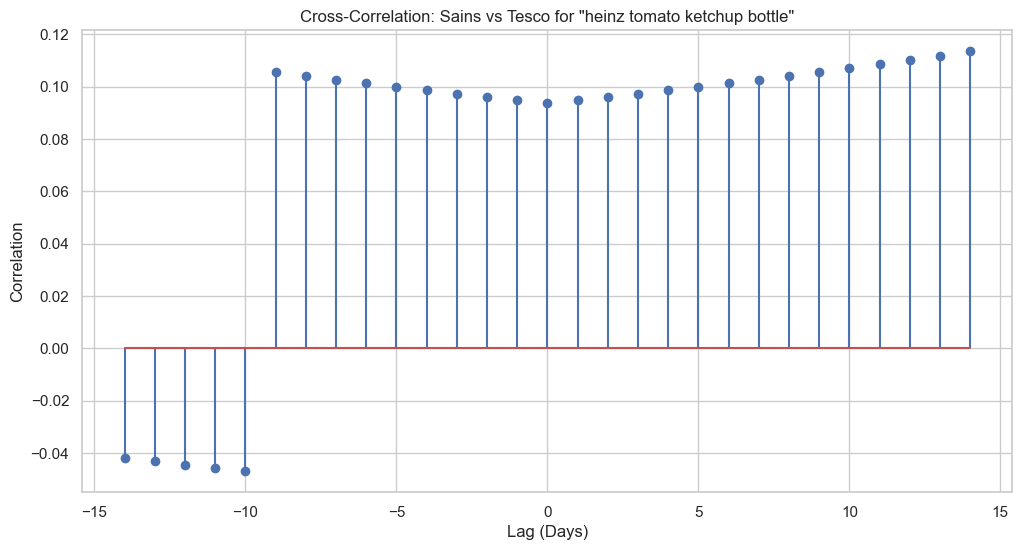

In [ ]:
# Convert date to datetime
df_canonical['date'] = pd.to_datetime(df_canonical['date'])

# Filter for the product and sort by date
product_name = 'heinz tomato ketchup bottle'
ts_data = df_canonical[df_canonical['canonical_name'] == product_name].sort_values('date')

# Pivot with aggregation to handle duplicates
ts_pivot = ts_data.pivot_table(
    index='date',
    columns='supermarket',
    values='prices',
    aggfunc='mean'
)


print("Available supermarkets in ts_pivot:", ts_pivot.columns.tolist())

supermarket1 = 'Sains'
supermarket2 = 'Tesco'

if supermarket1 not in ts_pivot.columns:
    print(f"Warning: '{supermarket1}' not found in the data for '{product_name}'. Skipping cross-correlation.")
elif supermarket2 not in ts_pivot.columns:
    print(f"Warning: '{supermarket2}' not found in the data for '{product_name}'. Skipping cross-correlation.")
else:
    ts_pivot[supermarket1] = ts_pivot[supermarket1].fillna(method='ffill')
    ts_pivot[supermarket2] = ts_pivot[supermarket2].fillna(method='ffill')

    ts_pivot_cleaned = ts_pivot.dropna(subset=[supermarket1, supermarket2])

    if len(ts_pivot_cleaned) < 2: 
        print(f"Not enough common data points between {supermarket1} and {supermarket2} for cross-correlation.")
    else:
        def cross_correlation(series1, series2, max_lag=14):
            """Computes the cross-correlation between two time series."""
            common_index = series1.index.intersection(series2.index)
            series1 = series1.loc[common_index]
            series2 = series2.loc[common_index]

            corrs = [series1.corr(series2.shift(lag)) for lag in range(-max_lag, max_lag + 1)]
            return np.array(corrs)

        lags = range(-14, 15)
        cc_tesco_asda = cross_correlation(ts_pivot_cleaned[supermarket1], ts_pivot_cleaned[supermarket2])

        plt.figure(figsize=(12, 6))
        plt.stem(lags, cc_tesco_asda)
        plt.title(f'Cross-Correlation: {supermarket1} vs {supermarket2} for "{product_name}"')
        plt.xlabel('Lag (Days)')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()



The x-axis is the "lag" in days. The y-axis is the correlation between the two price series at that lag.

* Lag = 0: The correlation between Sainsbury's price and Tesco's price on the same day.
* Lag = 5: The correlation between Sainsbury's price today and Tesco's price 5 days ago.
* Lag = -5: The correlation between Sainsbury's price today and Tesco's price 5 days in the future.

Negative Lags (Sainsbury's leads Tesco): Left side of the plot (lags -15 to -1). The correlations are all negative and very small (around -0.04). This means there is a very weak, almost nonexistent, negative relationship. If Sainsbury's price goes up, Tesco's price a few days later tends to go down slightly, but the effect is negligible. We can conclude that Sainsbury's does not appear to be a price leader for Tesco on this item.

Positive Lags (Tesco leads Sainsbury's): Right side (lags 1 to 14). The correlation is consistently positive and significant (around +0.10 to +0.11). The peak correlation occurs at a lag of around +13 days.

The Key Insight: This means that a change in Tesco's price today has the strongest positive correlation with Sainsbury's price 13 days later. In simpler terms, Tesco appears to be the price leader, and Sainsbury's is a follower, but with a significant delay of nearly two weeks. This is a fascinating strategic insight. Tesco makes a move, and Sainsbury's responds much later, perhaps at the start of their next major promotional cycle.